Experiment 1A - Full Dataset Experiment
1) Hyperparameters tuned with Hyperband
2) Use full set of dataset for training, validation, and testing (randomized)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import tokenize
import io
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt
import json
import pickle
from tensorflow.keras.utils import plot_model

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, SpatialDropout1D, Attention, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# this file is the cleaned output from the prior script mrp_main_fl.ipynb
df_code_py = pd.read_parquet('df_code_py.gzip')

In [5]:
df_code_py.head()

,academic_year_1,task,user,date,academic_year_0,upload,module,correct,hour_submitted,tokens,token_count,line_count,token_code_only,token_per_line
0,2017,add.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:11:41,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
1,2017,concat-lines.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:17:33,2016,#!/usr/bin/env python\n\na = str(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, str, (, raw_input, (, ), ), \n, b, ...",7.5
2,2017,goodbye.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 10:15:59,2016,"#!/usr/bin/env python\n\nprint ""Goodbye""\n",ca277,True,10,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",7,2,"[\n, print, ""Goodbye"", \n]",3.5
3,2017,less-than.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:14:22,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
4,2017,longest-line.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:51:28,2016,#!usr/bin/evn python\n\na = raw_input()\nb = r...,ca277,True,14,"[{'end': [1, 20], 'line': '#!usr/bin/evn pytho...",42,7,"[\n, a, =, raw_input, (, ), \n, b, =, raw_inpu...",6.0


In [6]:
df_code_py.shape

(378455, 14)

In [7]:
df_code_py_exp = df_code_py

In [8]:
df_code_py_exp.iloc[0].tokens

array([{'end': array([ 1, 21], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([1, 0], dtype=int64), 'string': '#!/usr/bin/env python', 'type': 61},
       {'end': array([ 1, 22], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([ 1, 21], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([2, 1], dtype=int64), 'line': '\n', 'start': array([2, 0], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([3, 1], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 0], dtype=int64), 'string': 'a', 'type': 1},
       {'end': array([3, 3], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 2], dtype=int64), 'string': '=', 'type': 54},
       {'end': array([3, 7], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 4], dtype=int64), 'string': 'int', 'type': 1},
       {'end': array([3, 8], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 7], dtype=int64), 'string': '(', 'type': 5

Model generation begins here

In [9]:
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50

Custom tokenizer function to apply to each line of code from the dataset

In [10]:
def tokenizer_custom(t_list):    
    
    if isinstance(t_list, np.ndarray):
        return t_list
    else:
        temp_tokens = None
        t_dict = None
        t_code_only = []
        with io.StringIO(t_list) as f:
            line = f.readline
            temp_tokens = tokenize.generate_tokens(line)
            try:
                for token in temp_tokens:
                    t_dict = token._asdict()
                    if t_dict["line"] == "\n" or t_dict["type"] == 0:
                        pass
                    elif t_dict["type"] != 61:
                        # tokenize only the code not comments
                        t_code_only.append(t_dict["string"])
            except:
                pass
        return np.array(t_code_only)

In [11]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters=None, lower=True, analyzer=tokenizer_custom)

In [12]:
tokenizer.fit_on_texts(df_code_py_exp["token_code_only"].values)
word_index = tokenizer.word_index

In [13]:
X_values = tokenizer.texts_to_sequences(df_code_py_exp["token_code_only"].values)
X_values = pad_sequences(X_values, maxlen=MAX_SEQUENCE_LENGTH)


In [14]:
# convert label column to values to prepare for training
Y_values = df_code_py_exp["correct"].astype(int).values

In [15]:
print(X_values[0], Y_values[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 18  4 47  2 51  2  3  3  1 61  4 47  2 51  2  3  3  1 16
 18 17 61  1] 1


In [16]:
print(df_code_py_exp.iloc[0].token_code_only, df_code_py_exp.iloc[0].correct)

['\n' 'a' '=' 'int' '(' 'raw_input' '(' ')' ')' '\n' 'b' '=' 'int' '('
 'raw_input' '(' ')' ')' '\n' 'print' 'a' '+' 'b' '\n'] True


In [17]:
# separate into train and test sets, train will be further split into train and validation sets later
X_train, X_test, Y_train, Y_test, I_train, I_test  = train_test_split(X_values, Y_values, df_code_py_exp.index, test_size = 0.1, random_state=42)

In [18]:
print("X_train: ", X_train.shape, "Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape, "Y_test: ", Y_test.shape)

X_train:  (340609, 100) Y_train:  (340609,)
X_test:  (37846, 100) Y_test:  (37846,)


In [19]:
print(X_train[0], Y_train[0])

[15 14  1  5 79 32 15 14  5  1 32  5 79  1  5 79 79 79  5 18  1 32  5 79
  1 32  5  1 32  5 79 79 32 15 14  1  5 79 32 15 14  5  1 32  5 79  1 32
  5 79 32 15 14  1 32  5 79 32 15 14  1 32  5 79 79 32 15 14  1 79 79 79
 79 79 32 15 14  1 32  5 79 79 32 15 14  6  1 10 14 11  1 32  5 79 79 32
 15 14  6  1] 0


In [20]:
print(df_code_py_exp.loc[I_train[0], "token_code_only"])

['\n' 'print' '"hello"' ... '.' 'py' '\n']


In [21]:
# set early stopping parameters
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [22]:
def model_builder(hp):    
    model_input = keras.Input(shape=(X_train.shape[1],))
    # embedding layer for ingesting the input
    x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1])(model_input)
    # tunable convolutional window
    hp_conv = hp.Int("units", min_value=3, max_value=7, step=1)
    # tunable stride
    hp_stride = hp.Int("stride", min_value=1, max_value=3, step=1)
    # CNN part of the model
    x = Conv1D(50, hp_conv, padding ="valid", activation ="relu", strides=hp_stride)(x)
    x = MaxPooling1D()(x)
    # tunable dropout rate
    hp_do = hp.Choice("dropout", values = [0.05, 0.1, 0.15, 0.2])
    # LSTM part of the model
    x = LSTM(50, activation="tanh", return_sequences=True, dropout=hp_do)(x)
    x = LSTM(25, activation="tanh", dropout=hp_do)(x)
    # output part of the model
    model_output = Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=model_input, outputs=model_output)
    # tunable optimizer
    hp_opt = hp.Choice("optimizer", values=["adam", "adafactor", "sgd"])
    model.compile(
    loss = "binary_crossentropy", 
    optimizer= hp_opt,
    metrics =["accuracy"],
    )
    return model

In [24]:
# initiate the hyperbandit tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name="adaptive_lms")


INFO:tensorflow:Reloading Tuner from .\adaptive_lms\tuner0.json


In [25]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[callback])

INFO:tensorflow:Oracle triggered exit


In [26]:
# retrieve best hyperparameters and apply to model training
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [27]:
best_hps.get("units")

3

In [28]:
best_hps.get("optimizer")

'adam'

In [29]:
best_hps.get("stride")

1

In [30]:
best_hps.get("dropout")

0.05

In [31]:
model = tuner.hypermodel.build(best_hps)

In [32]:
epochs = 100
batch_size = 128

In [33]:
# train the model
history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2,
    callbacks=[callback]
    )

Epoch 1/100
2129/2129 [==============================] - 52s 21ms/step - loss: 0.5523 - accuracy: 0.7367 - val_loss: 0.5277 - val_accuracy: 0.7466
Epoch 2/100
2129/2129 [==============================] - 42s 20ms/step - loss: 0.5162 - accuracy: 0.7508 - val_loss: 0.5237 - val_accuracy: 0.7505
Epoch 3/100
2129/2129 [==============================] - 42s 20ms/step - loss: 0.4956 - accuracy: 0.7602 - val_loss: 0.4837 - val_accuracy: 0.7679
Epoch 4/100
2129/2129 [==============================] - 42s 20ms/step - loss: 0.4803 - accuracy: 0.7680 - val_loss: 0.4723 - val_accuracy: 0.7757
Epoch 5/100
2129/2129 [==============================] - 44s 21ms/step - loss: 0.4679 - accuracy: 0.7743 - val_loss: 0.4621 - val_accuracy: 0.7788
Epoch 6/100
2129/2129 [==============================] - 43s 20ms/step - loss: 0.4567 - accuracy: 0.7801 - val_loss: 0.4509 - val_accuracy: 0.7817
Epoch 7/100
2129/2129 [==============================] - 42s 20ms/step - loss: 0.4466 - accuracy: 0.7847 - val_loss: 0

In [34]:
# pickle the model for usage by the next script (LIME)
model.save("CNN-LSTM.h5")

In [35]:
# pickle the tokenizer for later reusage by LIME
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Results and measurements of performance

In [36]:
test_accuracy = model.evaluate(X_test, Y_test)

1183/1183 [==============================] - 9s 8ms/step - loss: 0.3758 - accuracy: 0.8265


In [37]:
Y_pred = model.predict(X_test)

1183/1183 [==============================] - 8s 6ms/step


In [38]:
Y_pred = np.round(Y_pred, 0)

In [39]:
metric_report = classification_report(Y_test, Y_pred, output_dict=True)

In [40]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     27842
           1       0.69      0.63      0.66     10004

    accuracy                           0.83     37846
   macro avg       0.78      0.76      0.77     37846
weighted avg       0.82      0.83      0.82     37846



Plot results for visual comparison against comparable models from [Tarcsay](https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1110&context=scienmas)

In [41]:
tarcsay_cnn = {"precision":[0.9, 0.71], "recall":[0.76, 0.88], "f1-score":[0.83, 0.79], "accuracy":[0.81, 0.81]}
tarcsay_lstm = {"precision":[0.72, 0.66], "recall":[0.82, 0.53], "f1-score":[0.77, 0.59], "accuracy":[0.71, 0.71]}

<Figure size 640x480 with 0 Axes>

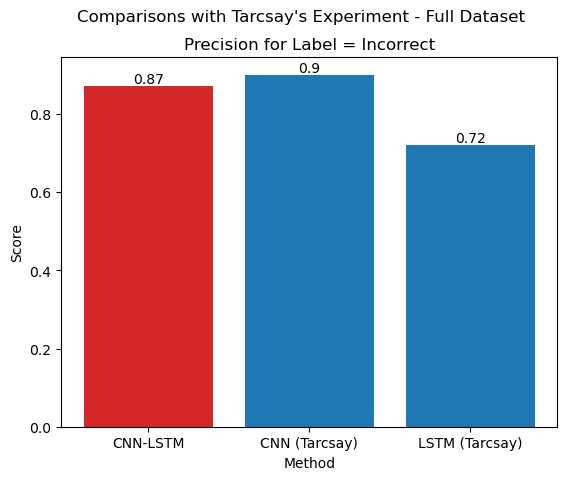

<Figure size 640x480 with 0 Axes>

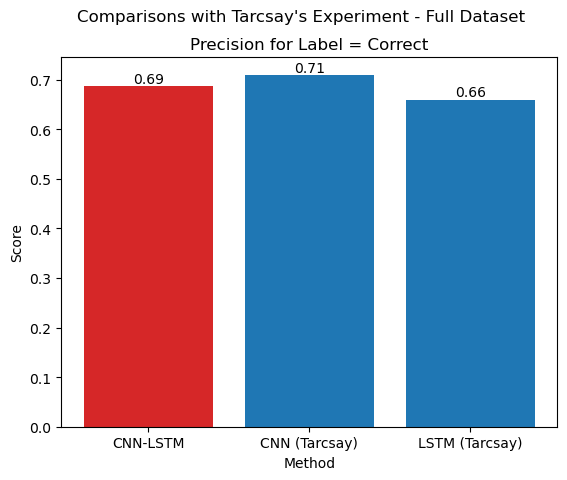

<Figure size 640x480 with 0 Axes>

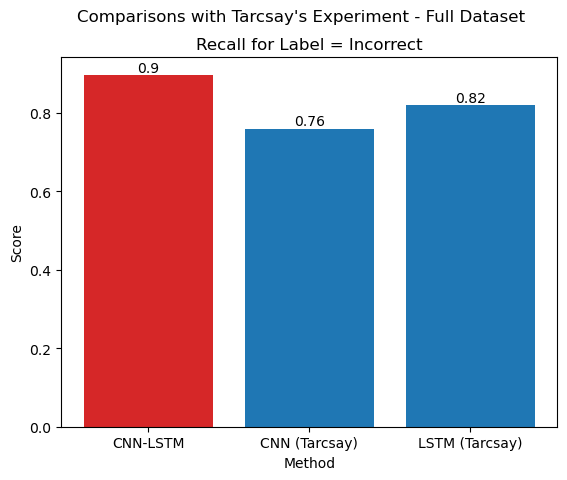

<Figure size 640x480 with 0 Axes>

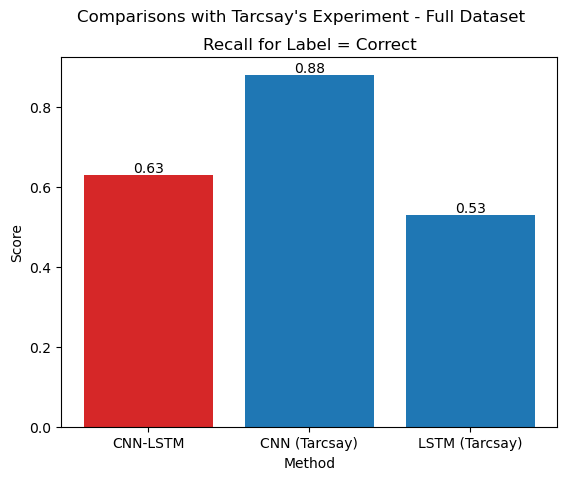

<Figure size 640x480 with 0 Axes>

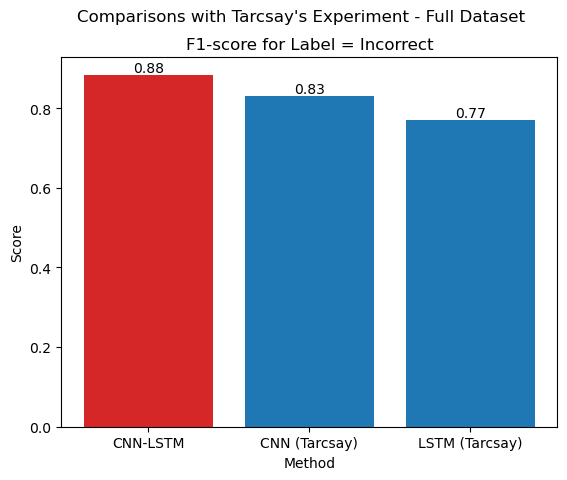

<Figure size 640x480 with 0 Axes>

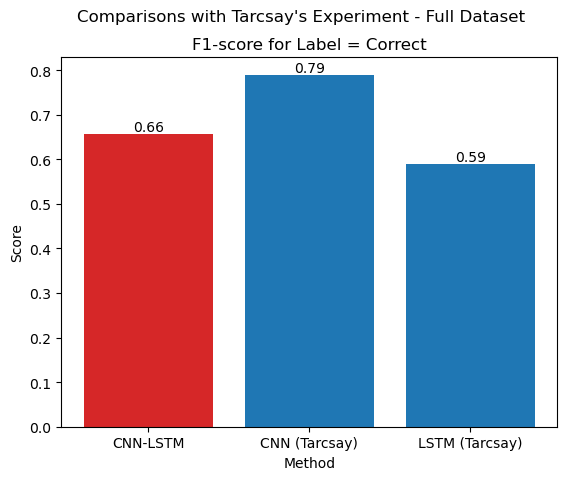

<Figure size 640x480 with 0 Axes>

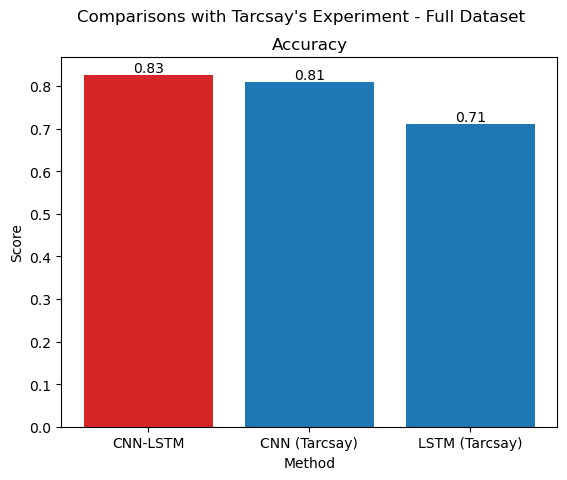

<Figure size 640x480 with 0 Axes>

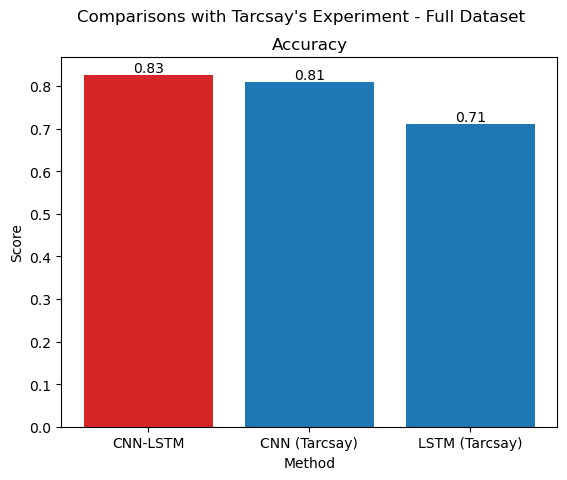

In [54]:
for metric in tarcsay_cnn.keys():
    for correct in [0, 1]:
        plt.figure()
        fig, ax = plt.subplots()
        classification = "Correct" if correct == 1 else "Incorrect"
        plt.title(str.capitalize(metric)+
                    ("" if metric == "accuracy" else " for Label = "+classification))
        plt.suptitle("Comparisons with Tarcsay's Experiment - Full Dataset")
        plt.xlabel("Method")
        plt.ylabel("Score")
        y = [(metric_report[metric] if metric == "accuracy" else metric_report[str(correct)][metric]),
                tarcsay_cnn[metric][correct], tarcsay_lstm[metric][correct]]
        p = ax.bar(["CNN-LSTM", "CNN (Tarcsay)", "LSTM (Tarcsay)"], y, 
                   color=["tab:red", "tab:blue", "tab:blue"])
        ax.bar_label(p, labels= [round(i,2) for i in y], label_type = "edge")
        plt.show()

In [55]:
print(confusion_matrix(Y_test, Y_pred))

[[24985  2857]
 [ 3708  6296]]


Validation Loss and Accuracy charts

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


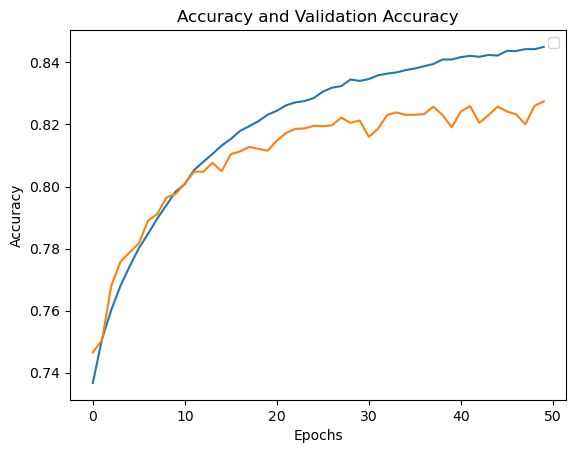

In [56]:
plt.title("Accuracy and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

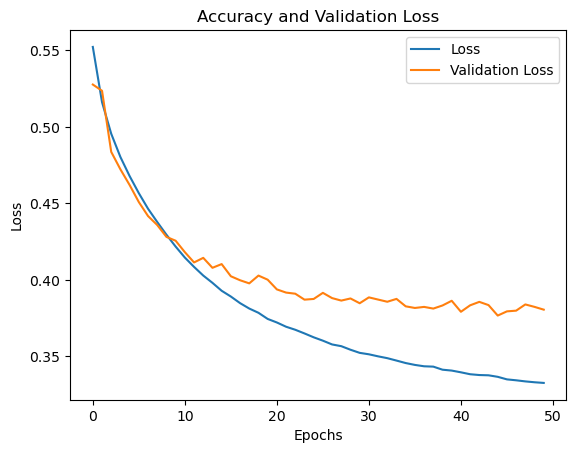

In [57]:
plt.title("Accuracy and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Testing the model

In [59]:
test_case_raw = 'print "Hello World"'

In [60]:
# createing a prediction function that can be used by LIME in the next script
def predict_fn (code):
    predictions = []
    if isinstance(code, list) or isinstance(code, np.ndarray):
        m_input = code
    else:
        m_input = [code]
    
    for m in m_input:
        m_input = tokenizer.texts_to_sequences([m])
        m_input = pad_sequences(m_input, maxlen=MAX_SEQUENCE_LENGTH)
        prob = model.predict(m_input)
        predictions.append([1-prob[0][0], prob[0][0]])
    return np.array(predictions)



In [61]:
predict_fn(test_case_raw)

1/1 [==============================] - 0s 27ms/step


array([[0.12553775, 0.87446225]])

In [62]:
predict_fn(test_case_raw)[0,1]

1/1 [==============================] - 0s 25ms/step


0.8744622468948364